In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.Data import CodonTable
from Bio.Restriction.Restriction_Dictionary import rest_dict
from Bio import Restriction
import tqdm

In [62]:
codontable = CodonTable.ambiguous_dna_by_id[1]
possible_nucls = codontable.nucleotide_alphabet + "-"
possible_nucls

'GATCRYWSMKHBVDN-'

In [63]:
PATH_TO_MULAL = "../data/interim/mulal.fasta"

### Generate table summarizing genomes site states

In [64]:
fasta = SeqIO.parse(PATH_TO_MULAL, "fasta")
ref_rec = next(fasta)
base_dct = {nucl: 0 for nucl in possible_nucls}
data = [base_dct.copy() for _ in range(len(ref_rec.seq))]
for i, nucl in enumerate(str(ref_rec.seq)):
    data[i][nucl] += 1

for rec in tqdm.tqdm(fasta, "Seqs", 56446):
    seq = str(rec.seq)
    for i, nucl in enumerate(seq):
        data[i][nucl] += 1


Seqs: 100%|█████████▉| 56445/56446 [02:04<00:00, 454.60it/s]


In [65]:
df = pd.DataFrame(data)
df.reset_index(inplace=True)
df.rename(columns={"index": "Pos"}, inplace=True)
df["Pos"] += 1
df.to_csv("../data/share/genomes_summary.tsv", sep="\t", index=None)
df.tail()

,Pos,G,A,T,C,R,Y,W,S,M,K,H,B,V,D,N,-
16564,16565,0,1,0,55313,0,0,0,0,0,0,0,0,0,0,53,1079
16565,16566,55267,16,0,0,0,0,0,0,0,0,0,0,0,0,58,1105
16566,16567,0,55265,0,1,0,0,0,0,0,0,0,0,0,0,54,1126
16567,16568,0,2,55207,7,0,0,0,0,0,0,0,0,0,0,58,1172
16568,16569,55099,10,1,1,0,0,0,0,0,0,0,0,0,0,61,1274


### Ungappy sites (currently unused)

In [66]:
ungappy = df.loc[np.where(df["-"].values == 0)]
print(ungappy.shape)
ungappy

(11133, 17)


,Pos,G,A,T,C,R,Y,W,S,M,K,H,B,V,D,N,-
579,580,0,0,56440,0,0,0,0,0,0,0,0,0,0,0,6,0
580,581,0,56439,0,0,0,0,0,0,0,0,0,0,0,0,7,0
581,582,0,0,56443,0,0,0,0,0,0,0,0,0,0,0,3,0
582,583,56442,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
584,585,1,56443,0,0,0,0,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14741,14742,0,0,1,56442,0,0,0,0,0,0,0,0,0,0,3,0
14742,14743,9,56433,0,1,0,0,0,0,0,0,0,0,0,0,3,0
14743,14744,0,0,0,56443,0,0,0,0,0,0,0,0,0,0,3,0
14744,14745,0,0,8,56435,0,0,0,0,0,0,0,0,0,0,3,0


### Fully constant sites

In [67]:
constant_pos = df.drop("Pos", axis=1).apply(lambda x: np.sum(x.values > 0) == 1, axis=1).values
df_const = df.loc[constant_pos]
df_const.head()

,Pos,G,A,T,C,R,Y,W,S,M,K,H,B,V,D,N,-
623,624,0,0,0,56446,0,0,0,0,0,0,0,0,0,0,0,0
624,625,56446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
625,626,56446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
636,637,0,0,0,56446,0,0,0,0,0,0,0,0,0,0,0,0
637,638,0,0,0,56446,0,0,0,0,0,0,0,0,0,0,0,0


#### Extract fully constant sequences 

In [68]:
prev = -10
x = df_const.Pos.values
cur_pos_set = set()
colection_of_sequential = []
for i in range(x.shape[0] - 1):
    if x[i] + 1 == x[i + 1]:
        cur_pos_set.add(x[i])
        cur_pos_set.add(x[i + 1])
    else:
        if len(cur_pos_set) > 3:
            colection_of_sequential.append(sorted(cur_pos_set))
        cur_pos_set = set()


In [69]:
colection_of_sequential

[[637, 638, 639, 640, 641, 642],
 [690, 691, 692, 693, 694],
 [1621, 1622, 1623, 1624],
 [3299, 3300, 3301, 3302, 3303, 3304],
 [4144, 4145, 4146, 4147],
 [4521, 4522, 4523, 4524],
 [4980, 4981, 4982, 4983],
 [7086, 7087, 7088, 7089, 7090],
 [7101, 7102, 7103, 7104, 7105],
 [9169, 9170, 9171, 9172, 9173],
 [10758, 10759, 10760, 10761, 10762],
 [12327, 12328, 12329, 12330],
 [13232, 13233, 13234, 13235],
 [13549, 13550, 13551, 13552, 13553, 13554, 13555, 13556],
 [14009, 14010, 14011, 14012]]

In [71]:
nucls = list("ACGT")
potential_sites = []
for sequential in colection_of_sequential:
    da = df_const[df_const.Pos.isin(sequential)][nucls]
    _pos = np.where(da.values == 56446)[1]
    seq = "".join([nucls[i] for i in _pos])
    potential_sites.append(seq)

potential_sites

['CCCCAT',
 'TACAC',
 'AAGC',
 'TTAACA',
 'TTCC',
 'CTCA',
 'AACC',
 'CACTG',
 'TTCTC',
 'ACACT',
 'CAATG',
 'AATA',
 'AAAA',
 'AACGCCTG',
 'TAGA']

In [72]:
mpr = str.maketrans("ACGT", "TGCA")
"ACTTTCG".translate(mpr)  # check

'TGAAAGC'

In [73]:
extended_potential_sites = []
for ps in potential_sites:
    new_ps = ps.translate(mpr)
    extended_potential_sites.append(ps)
    extended_potential_sites.append(new_ps[::-1])
print(extended_potential_sites)

['CCCCAT', 'ATGGGG', 'TACAC', 'GTGTA', 'AAGC', 'GCTT', 'TTAACA', 'TGTTAA', 'TTCC', 'GGAA', 'CTCA', 'TGAG', 'AACC', 'GGTT', 'CACTG', 'CAGTG', 'TTCTC', 'GAGAA', 'ACACT', 'AGTGT', 'CAATG', 'CATTG', 'AATA', 'TATT', 'AAAA', 'TTTT', 'AACGCCTG', 'CAGGCGTT', 'TAGA', 'TCTA']


#### Search for restriction sites in the fully constant sequences

In [74]:
for enzyme, propperties in rest_dict.items():
    esite = propperties["site"]
    if esite in extended_potential_sites:
        print(enzyme, esite)


BtsIMutI CAGTG


### Restriction site found - **BtsIMutI**. All used human mtDNA contain this site at least on one strand

### Need to find site, that do only cut on sequence

In [75]:
df["Stability"] = df.drop("Pos", axis=1).max(axis=1) / df.iloc[0, 1:].sum()
df

,Pos,G,A,T,C,R,Y,W,S,M,K,H,B,V,D,N,-,Stability
0,1,55139,0,2,2,0,0,0,0,0,0,0,0,0,0,77,1226,0.976845
1,2,1,55250,1,0,0,0,0,0,0,0,0,0,0,0,49,1145,0.978812
2,3,0,1,55267,23,0,0,0,0,0,0,0,0,0,0,50,1105,0.979113
3,4,3,2,3,55307,0,0,0,0,0,0,0,0,0,0,45,1086,0.979821
4,5,1,55317,2,14,0,0,0,0,0,0,0,0,0,0,44,1068,0.979999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16564,16565,0,1,0,55313,0,0,0,0,0,0,0,0,0,0,53,1079,0.979928
16565,16566,55267,16,0,0,0,0,0,0,0,0,0,0,0,0,58,1105,0.979113
16566,16567,0,55265,0,1,0,0,0,0,0,0,0,0,0,0,54,1126,0.979077
16567,16568,0,2,55207,7,0,0,0,0,0,0,0,0,0,0,58,1172,0.978050


In [76]:
df[
    (df["-"] == 0) &
    (df.Stability > 0.999) &
    (df[nucls].sum(axis=1) == df[nucls].max(axis=1))
]

,Pos,G,A,T,C,R,Y,W,S,M,K,H,B,V,D,N,-,Stability
579,580,0,0,56440,0,0,0,0,0,0,0,0,0,0,0,6,0,0.999894
580,581,0,56439,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0.999876
581,582,0,0,56443,0,0,0,0,0,0,0,0,0,0,0,3,0,0.999947
582,583,56442,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0.999929
585,586,56443,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0.999947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14737,14738,0,56443,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0.999947
14739,14740,0,56443,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0.999947
14740,14741,0,56443,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0.999947
14743,14744,0,0,0,56443,0,0,0,0,0,0,0,0,0,0,3,0,0.999947


In [105]:
from Bio.Seq import Seq
from Bio.Restriction import Analysis, AllEnzymes

In [135]:
pBs_mcs = 'GGTACCGGGCCCCCCCTCGAGGTCGACGGTATCGATAAGCTTGATATCGAATTCCTG'
pBs_mcs += 'CAGCCCGGGGGATCCACTAGTTCTAGAGCGGCCGCCACCGCGGTGGAGCTC'
seq = Seq(pBs_mcs)  # Multiple-cloning site of pBluescript SK(-)
a = Analysis(AllEnzymes, seq)

In [137]:
a.print_that()

AbaSI      :  10, 12, 13, 16, 17, 18, 19, 20, 22, 23, 24, 25, 25, 26, 27, 28,
               30, 30, 34, 36, 39, 40, 45, 48, 51, 52, 55, 56, 57, 58, 59, 60,
               66, 67, 68, 70, 73, 74, 74, 75, 76, 78, 79, 82, 83, 84, 86, 88,
               90, 91, 92, 93, 94, 96, 98, 101, 102, 104, 105, 107, 108.
BmeDI      :  2, 7, 8, 8, 9, 9, 13, 14, 15, 16, 17, 18, 19, 19, 21, 21, 22, 25,
               27, 28, 29, 30, 34, 36, 39, 43, 43, 49, 51, 57, 57, 58, 60, 61,
               64, 64, 65, 65, 66, 66, 67, 68, 74, 75, 77, 77, 83, 83, 85, 87,
               88, 89, 91, 92, 93, 95, 96, 97, 98, 99, 99, 100, 101, 102, 103,
               105.
YkrI       :  10, 12, 13, 16, 16, 17, 19, 20, 21, 22, 23, 24, 25, 25, 26, 27,
               29, 30, 34, 35, 38, 40, 44, 48, 51, 51, 55, 56, 57, 58, 59, 59,
               65, 66, 68, 69, 72, 73, 74, 74, 76, 78, 79, 82, 82, 83, 85, 88,
               90, 91, 91, 93, 94, 96, 97, 100, 101, 103, 104, 106, 107.
FspEI      :  5, 12, 19, 24, 25, 26, 27, 28, 

In [139]:
# a.mapping

In [144]:
_s = {1, 2}
{k: v for k, v in a.mapping.items() if len(v) in _s}

{BaeGI: [12],
 Lra68I: [77],
 HincII: [25],
 DpnI: [70],
 BsnI: [10, 89],
 BfaI: [75, 81],
 AbsI: [17],
 SpnRII: [16, 17],
 BsrBI: [86],
 Sau96I: [8, 9],
 SmlI: [17],
 SgrBI: [99],
 BseLI: [19],
 Aod1I: [68],
 BsiHKAI: [108],
 BstSLI: [12],
 HpyCH4III: [29],
 AluI: [40, 106],
 Nli3877I: [21, 66],
 Asp718I: [2],
 Cfr42I: [99],
 SpeI: [74],
 BspDI: [33],
 Alw21I: [108],
 RsaI: [4],
 BstYI: [68],
 ApaI: [12],
 BceSIV: [50, 71],
 BsoBI: [17, 62],
 Kzo9I: [68],
 MflI: [68],
 NdeII: [68],
 XapI: [50],
 BshVI: [33],
 AsuI: [8, 9],
 Sth302II: [7, 64],
 ApoI: [50],
 BinI: [63, 76],
 DpnII: [68],
 BmgT120I: [8, 9],
 BsiHKCI: [17, 62],
 BspMAI: [60],
 GdiII: [87],
 HpyCH4V: [58],
 BstSFI: [56],
 Sau3AI: [68],
 TspMI: [62],
 Eco88I: [17, 62],
 Cba13II: [51],
 Hpy178III: [81],
 SfeI: [56],
 MwoI: [95],
 BsuTUI: [33],
 KpnI: [6],
 BstXI: [100],
 HpyAXVI_mut2: [23],
 EcoICRI: [106],
 BstFNI: [98],
 MnlI: [13, 26],
 UcoMSI: [96],
 BslI: [19],
 HaeIII: [10, 89],
 BshFI: [10, 89],
 Hpy8I: [25],
 BspFNI:

In [140]:
for RS, positions in a.mapping.items():
    break

In [146]:
RS.site

'CCGC'

In [158]:
print(RS)

SsiI


In [159]:
5*60/20

15.0

In [100]:
# SsiI: [86, 90, 96, 98]
rest_dict["SsiI"]

{'charac': (1, -1, None, None, 'CCGC'),
 'compsite': '(?=(?P<SsiI>CCGC))|(?=(?P<SsiI_as>GCGG))',
 'dna': None,
 'freq': 256.0,
 'fst3': -1,
 'fst5': 1,
 'inact_temp': 65,
 'opt_temp': 37,
 'ovhg': -2,
 'ovhgseq': 'CG',
 'results': None,
 'scd3': None,
 'scd5': None,
 'site': 'CCGC',
 'size': 4,
 'substrat': 'DNA',
 'suppl': ('B',)}

In [103]:
seq[80: 95]

Seq('TAGAGCGGCCGCCAC')

In [61]:
import random
from collections import Counter
from multiprocessing import Pool

import pandas as pd
from Bio.Restriction import Analysis, AllEnzymes
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import tqdm

PATH_TO_SEQS = "../data/raw/sequence.fasta"
THREADS = 24

fasta = SeqIO.parse(PATH_TO_SEQS, "fasta")
enzymes = AllEnzymes.copy()


def cleanup_enzymes(prob=0.01):
    """don't do it"""
    fasta = SeqIO.parse(PATH_TO_SEQS, "fasta")
    n = 0
    pot_rs = []
    for rec in tqdm.tqdm(fasta, "Seqs", 56446):
        if random.random() > prob:
            continue
        n += 1
        anal = Analysis(enzymes, rec.seq, linear=False)
        anal.mapping # dict[RS_name, positions]
        
        for rest_enz, positions in anal.mapping.items():
            if len(positions) == 1:
                pot_rs.append(rest_enz)

    ctr = Counter(pot_rs)
    m = 0
    for enz, amount in ctr.items():
        if amount != n:
            if enz in enzymes:
                enzymes.remove(enz)
                m += 1
    print(f"Removed {m} enzymes")
    

def extract_restr_enz(rec: SeqRecord) -> list:
    anal = Analysis(enzymes, rec.seq, linear=False)
    anal = Analysis(enzymes, rec.seq, linear=False)
    pot_rs = []
    for restr_enz, positions in anal.with_N_sites(1).items():
        pos = positions[0]
        re_name = repr(restr_enz)
        site = restr_enz.site

        one_data = {
            "RE": re_name,
            "Site": site,
            "SeqName": rec.description,
            "CutPos": pos,
        }
        pot_rs.append(one_data)
    return pot_rs

In [66]:
rec = next(fasta)
pd.DataFrame(extract_restr_enz(rec))

,RE,Site,SeqName,CutPos
0,BmtI,GCTAGC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,4588
1,NmeA6CIII,GCCGAC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,5940
2,RceI,CATCGAC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,14830
3,Eco47III,AGCGCT,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,4535
4,NgoMIV,GCCGGC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,935
...,...,...,...,...
96,AsuNHI,GCTAGC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,4584
97,BbvCI,CCTCAGC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,13042
98,PsuI,RGATCY,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,14262
99,BbsI,GAAGAC,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...,2733


In [62]:
len(enzymes), len(AllEnzymes)

(978, 978)

In [67]:
# 23 min or 54 min
fasta = SeqIO.parse(PATH_TO_SEQS, "fasta")
with Pool(THREADS) as p:
    collection_of_pot_rs = p.map(extract_restr_enz, fasta)

In [68]:
pot_rs = []
for xx in collection_of_pot_rs:
    for x in xx:
        pot_rs.append(x)  

In [69]:
df = pd.DataFrame(pot_rs)

In [70]:
# df.to_csv("../data/processed/re.csv", index=None)

In [90]:
df_counts = df.RE.value_counts().reset_index()
df_counts.columns = ["RE", "CuttedSeqs"]
df_counts.to_csv("../data/share/cuted_seqs_num.csv", index=None)

<AxesSubplot:>

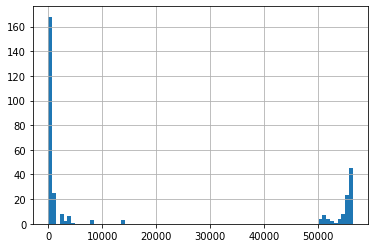

In [85]:
df.RE.value_counts().hist(bins=80)

In [13]:
ctr = Counter(pot_rs)

In [14]:
most_frequent_rs = {r: v for r, v in ctr.items() if v > 56446 - 1000}
most_frequent_rs

{XhoI: 56251,
 BstSNI: 56280,
 Sfr274I: 56251,
 SlaI: 56251,
 PaeR7I: 56251,
 SnaBI: 56280,
 SciI: 56251,
 Eco105I: 56280}

In [15]:
print("Enzyme", "Site", "#Cutted mtDNA", sep="\t")
for rs, num in most_frequent_rs.items():
    print(rs, rs.site, num, sep="\t")

Enzyme	Site	#Cutted mtDNA
XhoI	CTCGAG	56251
BstSNI	TACGTA	56280
Sfr274I	CTCGAG	56251
SlaI	CTCGAG	56251
PaeR7I	CTCGAG	56251
SnaBI	TACGTA	56280
SciI	CTCGAG	56251
Eco105I	TACGTA	56280


In [51]:
print("Enzyme", "Site", "#Cutted mtDNA", sep="\t")
for rs, num in most_frequent_rs.items():
    print(rs, rs.site, num, sep="\t")

Enzyme	Site	#Cutted mtDNA
Bsu15I	ATCGAT	56384
Bsa29I	ATCGAT	56384
ClaI	ATCGAT	56384
BseCI	ATCGAT	56384
BshVI	ATCGAT	56384
BspDI	ATCGAT	56384
BsuTUI	ATCGAT	56384


In [45]:
repr(rs), rs

('BsuTUI', BsuTUI)